### Random Forest 

In [157]:
sc_X = StandardScaler()
X_train = sc_X.fit_transform(X_train_pca)
X_test = sc_X.transform(X_test_pca)

In [159]:
cm = confusion_matrix(y_test_pca, y_pred)
conf = pd.DataFrame(cm, index=['NON HFT','MIX', 'HFT'],
columns=['predicted_NON_HFT', 'predicted_MIX', 'predicted_HFT'])
conf

,predicted_NON_HFT,predicted_MIX,predicted_HFT
NON HFT,60,165,10
MIX,13,1964,34
HFT,2,229,192


In [160]:
print('Accuracy Score:', metrics.accuracy_score(y_test_pca, y_pred))

class_report=classification_report(y_test_pca, y_pred)
print(class_report)

Accuracy Score: 0.8302735106781566
              precision    recall  f1-score   support

           0       0.80      0.26      0.39       235
           1       0.83      0.98      0.90      2011
           2       0.81      0.45      0.58       423

    accuracy                           0.83      2669
   macro avg       0.82      0.56      0.62      2669
weighted avg       0.83      0.83      0.80      2669



Here the problem of the unbalanced dataset is felt. The MIX class which is majoritary is really often predicted, and so, eventhough the overall accuracy is good, the one for the minoritary classes is not. 

And we have the proof, when looking at the F1 scores of the NON HFT and HFT classes that those features aren't good (0.39 for NON-HFT and 0.58 for HFT)

##### Re-balancing 

Since our dataset after cleaning is quite unbalanced, in order to have a better efficiency of our RandomForest, we need to find solutions to re-balanced it.

Since we have a number of observations which is large enough to make fair predictions, what we're gonna do is to procede by under-sampling, meaning that we're gonna reduce the majority class by take a sample of it. The other well-known method is the over sampling of the minority classes, but since we have 2 minorities, and 1 majority, we will have to do the work twice, against one for the under-sampling.

Now, what we want to do, is to define a balanced ratio that we want to achieve. Since we want kind of equal representation of the different classes, with almost the same number of observations, we want for the number of MIX trader in the final sample :

nb(MIX) = (nb(HFT) + nb(NON-HFT)) / 2

In [161]:
df_pca['target'].value_counts()

1    9974
2    2108
0    1260
Name: target, dtype: int64

In [162]:
nb_mix = (df_pca['target'].value_counts()[0] + df_pca['target'].value_counts()[2]) / 2
nb_mix

1684.0

So we need to select 1684 observations of type MIX to obtain a good balanced dataset.

We can select them by many way, like for instance with the K-Nearest Neighboors by selecting MIX traders for who the distance with HFT or NON-HFT is the smallest, but since we already did a lot of data pre-processing, associated with a lot of data cleaning, we already have good enough observations in term of quality, so we can select the subsample of MIX traders randomly.

In [163]:
from random import sample

part1 = df_pca.loc[df_pca['target'] == 0]
part2 = df_pca.loc[df_pca['target'] == 2]
part3 = df_pca.loc[df_pca['target'] == 1].sample(n = int(nb_mix))

# here we decompose our dataset between the NON-HFT (part1), the HFT (part2), and the subsampling of the MIX (part3)

In [164]:
df_pca_sample = pd.concat([part1, part2, part3])
df_pca_sample = df_features_sample.sample(frac=1).reset_index(drop=True) # we shuffle the dataset
df_pca_sample.head(10)

,Trader,type,Index,Share,Day,OTR,OCR,OMR,min_time_two_events,mean_time_two_events,10_p_time_two_events,med_time_two_events,25_p_time_two_events,75_p_time_two_events,90_p_time_two_events,max_time_two_events,min_lifetime_cancel,mean_lifetime_cancel,10_p_lifetime_cancel,med_lifetime_cancel,25_p_lifetime_cancel,75_p_lifetime_cancel,90_p_lifetime_cancel,max_lifetime_cancel,NbTradeVenueMic,MaxNbTradesBySecond,MeanNbTradesBySecond,min_dt_TV1,mean_dt_TV1,med_dt_TV1,min_dt_TV1_TV2,mean_dt_TV1_TV2,med_dt_TV1_TV2,min_dt_TV1_TV3,mean_dt_TV1_TV3,med_dt_TV1_TV3,min_dt_TV1_TV4,mean_dt_TV1_TV4,med_dt_TV1_TV4,NbSecondWithAtLeatOneTrade,target,jours
0,Baileywick,HFT,6060,Isin_22,Date_22,6.607930,3.171247,20.547945,0.0,311.483364,0.016123,23.402214,0.961496,117.421350,311.860700,31547.6330,0.000532,179.595677,0.137710,31.217867,3.695120,139.748260,310.130860,30561.93200,13,14,1.615385,0.001000,145.289645,72.044000,0.001000,125.827169,50.175000,0.001000,125.274098,50.175000,0.001000,125.274098,50.175000,221,2,22
1,Trader_264,MIX,52134,Isin_20,Date_2,10.386749,2.649764,51.853846,0.0,35.712348,0.000906,1.466691,0.099294,8.837297,20.457806,30591.0980,0.000533,28.678789,0.080271,1.928416,0.142875,8.971242,19.387188,30591.09800,17,62,2.462687,0.001000,36.001603,15.631000,0.001000,33.803037,13.990000,0.001000,36.969454,17.655000,0.001000,38.868076,16.242000,670,1,2
2,Max the Sheepdog,NON HFT,74818,Isin_115,Date_14,3.666667,4.800000,132.000000,0.0,1630.688585,0.000069,25.868065,6.250323,93.974464,591.228330,33597.0080,0.001407,2408.665017,2.298800,31.641052,9.362380,89.605870,307.554630,32341.29900,13,10,1.626087,0.000061,247.169268,137.747221,0.000012,298.123873,174.052660,0.000385,230.803854,174.052660,0.002603,264.552050,174.052660,115,0,14
3,Trader_161,HFT,16715,Isin_89,Date_12,10.787781,2.779619,30.225225,0.0,740.159824,0.000342,0.525716,0.000570,18.769232,68.305180,37497.0000,0.000334,899.525288,0.000522,2.812208,0.002347,22.500060,70.825930,37204.16000,7,14,2.102804,0.000018,90.245753,9.103535,0.000005,102.497746,1.051601,0.000002,112.643092,0.130612,0.000034,106.779468,0.001687,214,2,12
4,Evinrude,NON HFT,51081,Isin_17,Date_4,10.944444,2.614218,91.933333,0.0,596.117398,0.000425,1.353013,0.000732,35.828632,139.855990,37499.9960,0.000240,662.075942,0.000514,4.877582,0.002800,44.696440,136.002940,37218.63300,10,16,2.470238,0.000029,109.653643,28.116206,0.000013,119.019496,13.993565,0.000026,132.777531,34.772391,0.000052,138.663200,34.772391,168,0,4
5,Max the Sheepdog,NON HFT,74687,Isin_71,Date_6,2.934066,5.235294,29.666667,0.0,92.302345,0.000000,0.305123,0.000067,24.898884,138.121120,2924.4866,0.000637,163.694437,0.077175,14.996881,0.550237,55.999386,432.355560,2924.48660,15,30,2.475000,0.000003,21.961148,0.001082,0.000003,29.143052,0.000277,0.000003,181.608554,0.182727,0.000003,85.627246,0.005110,120,0,6
6,Trader_341,HFT,71231,Isin_102,Date_13,3.530702,4.600000,201.250000,0.0,1380.923437,0.000027,0.001423,0.000285,1.280876,159.071410,37500.0000,0.000057,848.713876,0.000334,0.163001,0.001031,2.305008,87.984210,33728.89000,18,21,2.401460,0.000016,58.558136,0.001969,0.000008,77.629243,0.754660,0.000016,70.424777,0.066419,0.000016,72.357273,0.777619,274,2,13
7,Duchess,MIX,38410,Isin_112,Date_7,11.832451,7.487723,1.790977,0.0,197.755151,1.082583,20.382631,3.800487,68.603650,198.203450,41591.0200,0.036904,645.231487,1.065116,19.780940,2.939424,102.390230,303.888670,41591.02000,8,46,1.812339,0.000001,63.978396,26.488205,0.000063,48.784797,20.763271,0.000060,51.120685,24.963225,0.000090,53.360210,27.202183,389,1,7
8,Trader_341,HFT,72110,Isin_70,Date_29,2.431438,7.343434,121.166667,0.0,120.529359,0.000000,5.147243,0.000096,15.022766,30.013315,33713.7000,0.019852,20.886679,5.216871,15.007866,14.799207,29.955864,44.944164,75.00345,8,11,2.333333,0.000015,90.051130,0.298491,0.000003,63.533384,0.002780,0.000008,63.024694,0.002780,0.000010,79.769263,0.139801,204,2,29
9,Baileywick,HFT,5643,Isin_59,Date_3,10.110390,2.847737,31.296482,0.0,83.613913,0.000905,4.19984

So now, we need to redo the PCA reduction of dimensionality on this balanced sample, and then evaluate our models with the corresponding data.

In [169]:
from sklearn.model_selection import train_test_split
X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(df_pca_sample.drop(['target', 'Trader', 'type', 'Share', 'Day'], axis = 1), df_pca_sample['target'], test_size = 0.2)

In [170]:
pca = PCA(n_components = 18)
X_train_pca = pca.fit_transform(X_train_pca)
X_test_pca = pca.transform(X_test_pca)
explained_variance = pca.explained_variance_ratio_
print(explained_variance)

[6.36664168e-01 3.07501831e-01 5.44962370e-02 1.03692492e-03
 1.21708319e-04 7.74119830e-05 4.79292507e-05 2.53235011e-05
 1.16021893e-05 7.38997838e-06 2.59721293e-06 2.02649465e-06
 1.57684296e-06 1.10507429e-06 6.99414306e-07 5.14200738e-07
 2.57553331e-07 2.09984212e-07]


Let's perform the Random Forest with those Data.

In [215]:
sc_X = StandardScaler()
X_train = sc_X.fit_transform(X_train_pca)
X_test = sc_X.transform(X_test_pca)

In [216]:
classifier = RandomForestClassifier(n_estimators = 200, criterion = 'entropy', random_state = 0)
classifier.fit(X_train,y_train_pca)

y_pred = classifier.predict(X_test)

In [217]:
cm = confusion_matrix(y_test_pca, y_pred)
conf = pd.DataFrame(cm, index=['NON HFT','MIX', 'HFT'],
columns=['predicted_NON_HFT', 'predicted_MIX', 'predicted_HFT'])
conf

,predicted_NON_HFT,predicted_MIX,predicted_HFT
NON HFT,250,17,4
MIX,16,301,13
HFT,1,5,404


In [174]:
print('Accuracy Score:', metrics.accuracy_score(y_test_pca, y_pred))

class_report=classification_report(y_test_pca, y_pred)
print(class_report)

# much better

Accuracy Score: 0.9446092977250248
              precision    recall  f1-score   support

           0       0.94      0.92      0.93       271
           1       0.93      0.91      0.92       330
           2       0.96      0.99      0.97       410

    accuracy                           0.94      1011
   macro avg       0.94      0.94      0.94      1011
weighted avg       0.94      0.94      0.94      1011



##### ROC Curve 

Now we are going to plot the ROC Curve for NON HFT and HFT in a on VS all analysis. The ROC curve is the relation between the true positive rate and the false positive rate, the perfect model is the one with 100% of true positive and 0% of false positive. It allows us to evaluate the performance of the model for different classification threeshold.

In [200]:
from sklearn.preprocessing import LabelBinarizer

label_binarizer = LabelBinarizer().fit(y_train_pca)
y_onehot_test = label_binarizer.transform(y_test_pca)
y_onehot_pred = label_binarizer.transform(y_pred)
y_onehot_test.shape  

# we create an encoder for each observation of our test set (like a dummy variable for each possible target) and we do the
# same thing for our predictions

(1011, 3)

In [201]:
label_binarizer.transform([2]) # here is an example with the target = 2 (so the HFT class) of the encoder 

array([[0, 0, 1]])

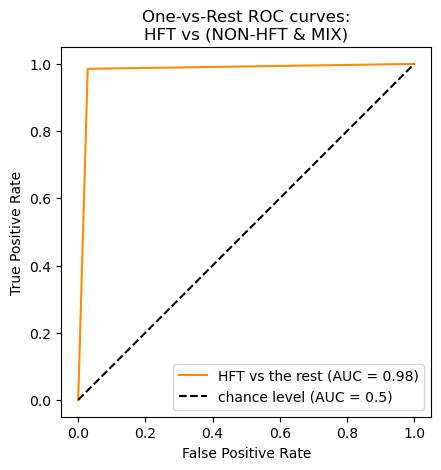

In [202]:
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay

RocCurveDisplay.from_predictions(
    y_onehot_test[:, 2],
    y_onehot_pred[:, 2],
    name="HFT vs the rest",
    color="darkorange",
)
plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("One-vs-Rest ROC curves:\nHFT vs (NON-HFT & MIX)")
plt.legend()
plt.show()

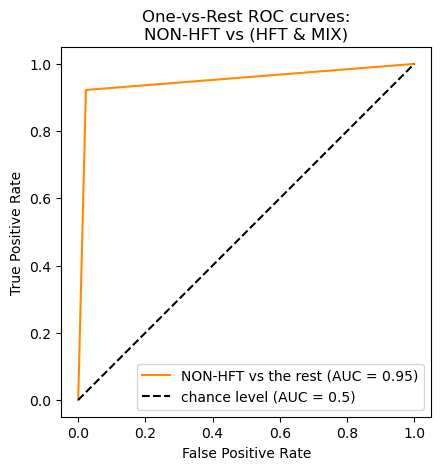

In [203]:
RocCurveDisplay.from_predictions(
    y_onehot_test[:, 0],
    y_onehot_pred[:, 0],
    name="NON-HFT vs the rest",
    color="darkorange",
)
plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("One-vs-Rest ROC curves:\nNON-HFT vs (HFT & MIX)")
plt.legend()
plt.show()

##### Hyperparameters 

In [213]:
criterion = ['gini', 'entropy']
n_estimators = []
min_samples_leaf = []

i = 50
j = 50

while i < 200:
    n_estimators.append(i)
    i += 10
    
while j < 200:
    min_samples_leaf.append(j)
    j += 10

In [214]:
estimator = RandomForestClassifier()

param_grid = { 
        "criterion" : criterion,
        "n_estimators" : n_estimators,
        "min_samples_leaf" : min_samples_leaf
        }

In [190]:
X_train.head()

,Index,OTR,OCR,OMR,min_time_two_events,mean_time_two_events,10_p_time_two_events,med_time_two_events,25_p_time_two_events,75_p_time_two_events,90_p_time_two_events,max_time_two_events,min_lifetime_cancel,mean_lifetime_cancel,10_p_lifetime_cancel,med_lifetime_cancel,25_p_lifetime_cancel,75_p_lifetime_cancel,90_p_lifetime_cancel,max_lifetime_cancel,NbTradeVenueMic,MaxNbTradesBySecond,MeanNbTradesBySecond,min_dt_TV1,mean_dt_TV1,med_dt_TV1,min_dt_TV1_TV2,mean_dt_TV1_TV2,med_dt_TV1_TV2,min_dt_TV1_TV3,mean_dt_TV1_TV3,med_dt_TV1_TV3,min_dt_TV1_TV4,mean_dt_TV1_TV4,med_dt_TV1_TV4,NbSecondWithAtLeatOneTrade,jours
3154,31972,13.769470,4.237776,2.858991,0.0,240.033933,1.013297,24.212710,3.723059,102.805520,334.745200,35498.766,0.097610,476.648856,1.060913,21.935898,5.278212,75.886130,240.008090,35498.7660,7,24,1.653430,0.000001,104.932844,31.154292,0.000040,66.980668,26.116026,0.000040,60.407012,18.827629,0.000020,58.837756,16.831347,277,13
464,76166,4.858824,4.802326,15.296296,0.0,1030.638185,0.000004,0.399087,0.000008,5.350222,46.707195,33599.418,0.000706,1452.568309,0.033693,2.250074,0.300008,8.256986,61.998863,32342.6000,17,13,2.641975,0.000008,692.363627,59.678909,0.000008,551.129917,3.809007,0.000004,488.420238,0.103236,0.000008,556.795925,3.048867,81,1
4471,32996,6.196737,4.195582,4.383571,0.0,430.238211,0.000000,11.867826,2.022938,59.438732,199.183170,50529.883,0.129256,537.610949,1.355406,22.174140,5.907379,70.447235,173.824230,50529.8830,9,80,1.956446,0.000001,38.932008,3.037073,0.000060,100.942207,51.404492,0.000060,103.919123,38.357679,0.000060,107.133502,38.357679,574,15
1080,7503,6.391753,3.229167,25.833333,0.0,174.498563,0.000055,20.629911,0.231079,133.671590,381.023930,13677.651,0.000990,168.175945,0.086238,19.160543,0.379657,190.771820,525.483340,2410.0876,15,17,1.402235,0.001000,310.842925,132.471000,0.001000,238.974864,86.496000,0.001000,264.583200,115.418000,0.001000,268.123947,115.418000,179,10
4084,22926,2.739130,9.450000,23.625000,0.0,163.014164,0.000004,22.917566,0.001089,265.139500,506.030900,2546.386,0.245356,333.955893,0.394285,29.999868,3.931554,138.406310,1135.419000,2546.3860,8,21,1.721239,0.000093,137.858043,89.561770,0.000009,135.215173,89.561770,0.000002,113.049078,70.518627,0.000013,106.606917,38.221484,226,12


In [221]:
from sklearn.model_selection import GridSearchCV

CV_rfc = GridSearchCV(estimator=estimator, param_grid=param_grid, cv= 2)
CV_rfc.fit(X_train, y_train)

GridSearchCV(cv=2, estimator=RandomForestClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'min_samples_leaf': [50, 60, 70, 80, 90, 100, 110, 120,
                                              130, 140, 150, 160, 170, 180,
                                              190],
                         'n_estimators': [50, 60, 70, 80, 90, 100, 110, 120,
                                          130, 140, 150, 160, 170, 180, 190]})

In [223]:
CV_rfc.best_params_

{'criterion': 'entropy', 'min_samples_leaf': 70, 'n_estimators': 60}

##### Best Random Forest 

In [228]:
sc_X = StandardScaler()
X_train = sc_X.fit_transform(X_train_pca)
X_test = sc_X.transform(X_test_pca)

In [231]:
classifier = RandomForestClassifier(n_estimators = 60, criterion = 'entropy', min_samples_leaf = 70, random_state = 0)
classifier.fit(X_train,y_train_pca)

y_pred = classifier.predict(X_test)

In [232]:
cm = confusion_matrix(y_test_pca, y_pred)
conf = pd.DataFrame(cm, index=['NON HFT','MIX', 'HFT'],
columns=['predicted_NON_HFT', 'predicted_MIX', 'predicted_HFT'])
conf

,predicted_NON_HFT,predicted_MIX,predicted_HFT
NON HFT,192,45,34
MIX,45,256,29
HFT,11,14,385


In [233]:
print('Accuracy Score:', metrics.accuracy_score(y_test_pca, y_pred))

class_report=classification_report(y_test_pca, y_pred)
print(class_report)

Accuracy Score: 0.8239366963402571
              precision    recall  f1-score   support

           0       0.77      0.71      0.74       271
           1       0.81      0.78      0.79       330
           2       0.86      0.94      0.90       410

    accuracy                           0.82      1011
   macro avg       0.82      0.81      0.81      1011
weighted avg       0.82      0.82      0.82      1011



Our best random forest has lower accuracy than the non-optimized one, meaning that previously, we had overfitting, which is now resolved thanks to the K-cross validation.

In addition of this, we see that it performs better on HFT than on the others (see F1 score).

In [234]:
label_binarizer = LabelBinarizer().fit(y_train_pca)
y_onehot_test = label_binarizer.transform(y_test_pca)
y_onehot_pred = label_binarizer.transform(y_pred)
y_onehot_test.shape  

(1011, 3)

In [235]:
label_binarizer.transform([2])

array([[0, 0, 1]])

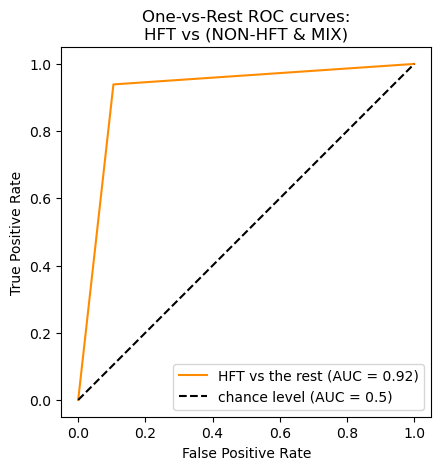

In [236]:
RocCurveDisplay.from_predictions(
    y_onehot_test[:, 2],
    y_onehot_pred[:, 2],
    name="HFT vs the rest",
    color="darkorange",
)
plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("One-vs-Rest ROC curves:\nHFT vs (NON-HFT & MIX)")
plt.legend()
plt.show()

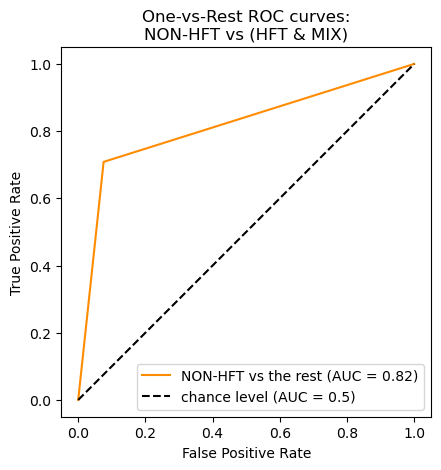

In [237]:
RocCurveDisplay.from_predictions(
    y_onehot_test[:, 0],
    y_onehot_pred[:, 0],
    name="NON-HFT vs the rest",
    color="darkorange",
)
plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("One-vs-Rest ROC curves:\nNON-HFT vs (HFT & MIX)")
plt.legend()
plt.show()

### Boosting 

In [177]:
from xgboost import XGBClassifier

In [225]:
classifier = XGBClassifier(n_estimators = 200, random_state = 0)
classifier.fit(X_train,y_train_pca)

y_pred = classifier.predict(X_test)

In [180]:
cm = confusion_matrix(y_test_pca, y_pred)
conf = pd.DataFrame(cm, index=['NON HFT','MIX', 'HFT'],
columns=['predicted_NON_HFT', 'predicted_MIX', 'predicted_HFT'])
conf

,predicted_NON_HFT,predicted_MIX,predicted_HFT
NON HFT,260,8,3
MIX,10,314,6
HFT,1,3,406


In [181]:
print('Accuracy Score:', metrics.accuracy_score(y_test_pca, y_pred))

class_report=classification_report(y_test_pca, y_pred)
print(class_report)

# even a little better

Accuracy Score: 0.9693372898120672
              precision    recall  f1-score   support

           0       0.96      0.96      0.96       271
           1       0.97      0.95      0.96       330
           2       0.98      0.99      0.98       410

    accuracy                           0.97      1011
   macro avg       0.97      0.97      0.97      1011
weighted avg       0.97      0.97      0.97      1011



In [207]:
label_binarizer = LabelBinarizer().fit(y_train_pca)
y_onehot_test = label_binarizer.transform(y_test_pca)
y_onehot_pred = label_binarizer.transform(y_pred)
y_onehot_test.shape  

# we create an encoder for each observation of our test set (like a dummy variable for each possible target) and we do the
# same thing for our predictions

(1011, 3)

In [208]:
label_binarizer.transform([2])

array([[0, 0, 1]])

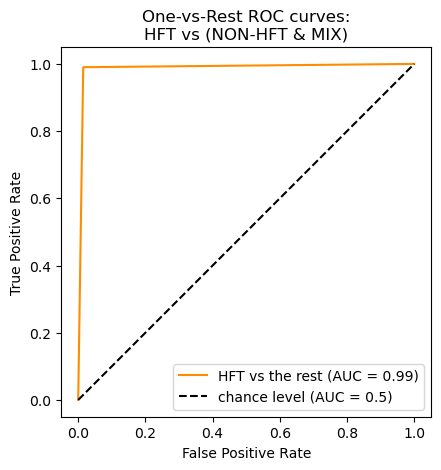

In [209]:
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay

RocCurveDisplay.from_predictions(
    y_onehot_test[:, 2],
    y_onehot_pred[:, 2],
    name="HFT vs the rest",
    color="darkorange",
)
plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("One-vs-Rest ROC curves:\nHFT vs (NON-HFT & MIX)")
plt.legend()
plt.show()

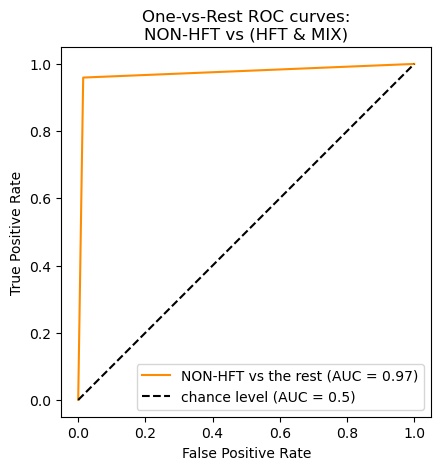

In [210]:
RocCurveDisplay.from_predictions(
    y_onehot_test[:, 0],
    y_onehot_pred[:, 0],
    name="NON-HFT vs the rest",
    color="darkorange",
)
plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("One-vs-Rest ROC curves:\nNON-HFT vs (HFT & MIX)")
plt.legend()
plt.show()

##### Hyperparameters

In [224]:
params = {
    'n_estimators': [100, 200, 500],
    'learning_rate': [0.01,0.05,0.1],
    'booster': ['gbtree', 'gblinear'],
    'gamma': [0, 0.5, 1],
}



In [227]:
gs2 = GridSearchCV(XGBClassifier(n_jobs=-1), params, n_jobs=-1, cv=KFold(n_splits=3), scoring='roc_auc')
gs2.fit(X_train, y_train_pca)

print('Best score:', gs2.best_score_)
print('Best score:', gs2.best_params_)

KeyboardInterrupt: 

### Multinomial Regression

In [182]:
from numpy import mean
from numpy import std
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression

X = df_pca_sample.drop(['type', 'Share', 'Day', 'Trader', 'target'], axis=1)
y = df_pca_sample['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

model = LogisticRegression(multi_class='multinomial', solver='lbfgs')

In [183]:
model.fit(X_train, y_train)

C:\Users\33698\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(multi_class='multinomial')

In [185]:
predict = model.predict(X_test)
params = model.get_params()

In [186]:
cm = confusion_matrix(y_test_pca, predict)
conf = pd.DataFrame(cm, index=['NON HFT','MIX', 'HFT'],
columns=['predicted_NON_HFT', 'predicted_MIX', 'predicted_HFT'])
conf

,predicted_NON_HFT,predicted_MIX,predicted_HFT
NON HFT,70,87,114
MIX,77,81,172
HFT,88,106,216
